In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

import plotly.figure_factory as ff

In [3]:
trees = pd.read_csv('data/black_spruce.csv')

In [4]:
def jitter(data, amt=0.2):
    return data + amt * np.random.rand(len(data)) - amt/2.0

# Modeling and Classification

The modeling task we face is to explain the susceptibility of trees to windthrow.
Another way of putting it is that we need to build a model for a two-level nominal feature, fallen or standing. When the response variable is nominal, this modeling task is called *classification*, and in the case when there are only two levels, we call it *binary classification*.

In classification, we want to track how often we predict the correct category.  A count of the correct predictions is sometimes called the *zero-one error* because the loss function takes on one of two possible values: one when an incorrect prediction is made and zero for a correct prediction. If $ y $ is the observed value and $ \theta $ is the prediction, then we can express this loss function as follows:

$$
\begin{aligned} 
{\ell}(\theta, y) = 
\begin{cases} 0 &  &\text{when }\theta \text{ matches } y\\ 
       1 &  & \text{when } \theta \text{ is a mismatch for }y
\end{cases}
\end{aligned} 
$$

When we have collected data, $\mathbf{y} = [y_1 , \ldots, y_n] $, then the average loss is:

$$
\begin{aligned}
L(\theta, \mathbf{y}) &= \frac{1}{n} \sum_{i=1}^n {\ell}(\theta, y) \\
  &= \frac{\# \text{ mismatches}}{n} 
\end{aligned}
$$


In the case of a constant model (see {numref}`Chapter %s <ch:modeling>`), the minimizing value for $\theta$ must be one of the two possible categories. For any other value, all of our predictions are incorrect and the average loss is 1. Of the two possibilities, the most prevalent gives the smallest average loss.

In the case of the black spruce, we have the following proportions of standing and fallen trees:

In [5]:
pd.value_counts(trees['status'])/len(trees)

standing    0.65
fallen      0.35
Name: status, dtype: float64

So our prediction is that a tree stands, and the average loss for our dataset is $0.35$. 

This prediction is not particularly helpful or insightful. In our EDA of the trees data frame, we saw that the size of the tree is correlated with whether the tree stands or falls. Ideally we would incorporate this information into the model.

For convenience, we transform the nominal feature into a numeric data type where 1 stands for a fallen tree  and 0 for standing:

In [6]:
trees['status_0_1'] = (trees['status'] == 'fallen').astype(int)

This representation is useful in many ways. For example, the average of `status_0_1` is the proportion of fallen trees in the dataset.

In [7]:
pr_fallen = np.mean(trees['status_0_1'])
print(f"Proportion of fallen black spruce: {pr_fallen:0.2f}")

Proportion of fallen black spruce: 0.35


Typically when we want to model a relationship, we begin by making a scatter plot of the outcome variable against explanatory variable(s) (see {numref}`Chapter %s <ch:linear>`). But, now our outcome variable is a nominal feature. Again, the 0-1 representation of this feature is convenient for plotting. Below we plot the tree status against diameter, but we add a small amount of random noise to the status to help us see the density of 0 and 1 values at each diameter. As before, we jitter the diameter values too and adjust the opacity of the markers to reduce over-plotting. We also add a horizontal line at the proportion of fallen trees:

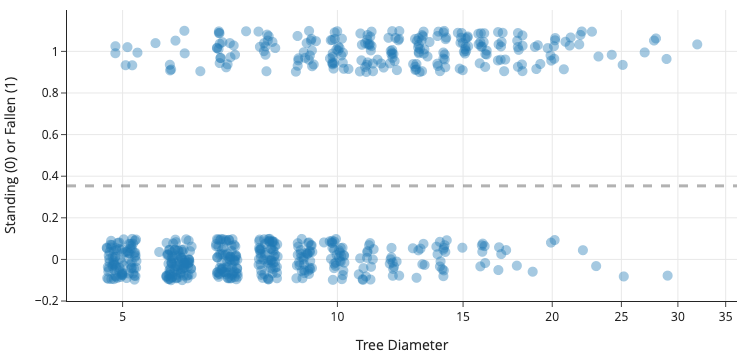

In [8]:
fig = px.scatter(x=jitter(trees['diameter'], amt=0.5), 
                 y = jitter(trees['status_0_1']), 
                 log_x=True, width=450, height=250)

fig.update_traces(marker=dict(opacity=0.4, size=10))
fig.add_hline(y=pr_fallen, line_width=3, line_dash="dash", line_color="black")
fig.update_layout(xaxis_title="Tree Diameter",
                  yaxis_title="Standing (0) or Fallen (1)")

fig

This scatter plot shows that the smaller trees are more likely to be standing than the larger trees. Notice that the average status for trees (0.35) essentially fits a constant model to the response variable. If we consider tree diameter as an explanatory feature, we should be able to improve the model.  

A starting place might be to compute a constant (the proportion of fallen trees) for different diameters. The following block of code divides tree diameter into intervals and computes the proportion of fallen trees in each bin.

In [12]:
splits=[4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 25, 32]
pr_split = np.zeros(len(splits)-1)
ct_split = np.zeros(len(splits)-1)

for i in range(0, len(splits)-1):
    sub_trees = trees['status_0_1'][((trees['diameter'] > splits[i]) & 
                                     (trees['diameter'] <= splits[i+1]))]
    pr_split[i] = np.mean(sub_trees)  
    ct_split[i] = len(sub_trees) 
    
tree_bins = pd.DataFrame({'proportion': pr_split, 
                          'count':ct_split, 'diameter':splits[1:]})    

We can plot these proportions against tree diameter:

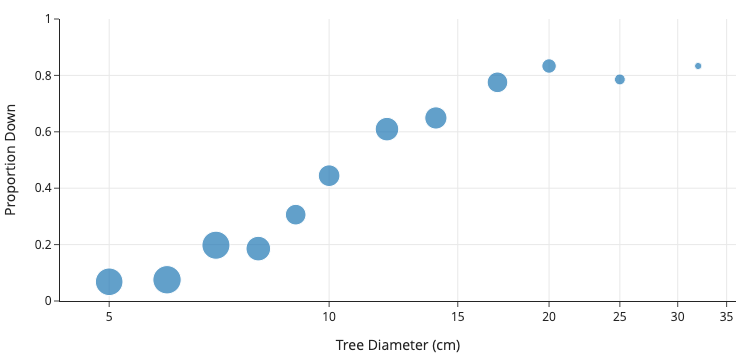

In [13]:
fig = px.scatter(tree_bins, x='diameter', y='proportion', size='count', log_x=True, 
        labels={'diameter':"Tree Diameter (cm)", 'proportion':"Proportion Down"},
         width=450, height=250)

fig.update_layout(yaxis_range=[0,1])
fig.show()

The size of the markers reflects the number of trees in the diameter bin. We can use these proportions to improve our model. For example, for a tree is 6 cm in diameter, we would classify it as standing, whereas for a 20 cm tree, our classification would be fallen. A natural starting place for binary classification is to model the observed proportions and then use these proportions to classify. We develop a model for the proportions next.  